In [2]:
# --- IMPORTS --------------------------------------------------------------------- #
import pandas as pd                                                                 #
import matplotlib.pyplot as plt     # plots                                         #
import pandas as pd                 # data processing                               #
import numpy as np                  # number processing                             #
import folium                       # easy maps, also interactive                   #
from folium.features import DivIcon # needed for map labels                         #    
import glob                         # glob2                                         #
import re                           # regix package, for following three functions  #
from matplotlib.gridspec import GridSpec # the cool subplots                        #
# --------------------------------------------------------------------------------- #

# --- FUNCTIONS ------------------------------------------------------------------- #
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.
    >>> alphanum_key("z23a")
    ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

def process_data(raw_data, column_names, date_start, date_end, resample_freq,encoding,header,data_type):
    """
    Processes the .csv data files. Outputs all as df and resampled as df_resampled.
    """
    data_list = []
    for x in raw_data:
        loop = pd.read_csv(x, sep=',', names=column_names, header=header, na_values='NaN',encoding=encoding, parse_dates=[0])
        data_list.append(loop)
    
    df = pd.concat(data_list, ignore_index=True)
    df = df.set_index('time')
    df = df.loc[date_start:date_end]
    df_resampled = df.astype(data_type).resample(resample_freq).mean()
    
    return df_resampled

def alphanum_key_second(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def initial_data_ingestion(data_path):
    """
    Use glob to make list of all data files to process
    """
    datlog_raw  = sorted(glob.glob(data_path + 'B*.dat'), key=alphanum_key_second)
    exo_raw     = sorted(glob.glob(data_path + 'E*.dat'), key=alphanum_key_second)
    ms3_raw     = sorted(glob.glob(data_path + 'M*.dat'), key=alphanum_key_second)
    ws_raw      = sorted(glob.glob(data_path + 'W*.dat'), key=alphanum_key_second)
    paraq1_raw  = sorted(glob.glob(data_path + 'PAR_aqua1*.dat'), key=alphanum_key_second)
    paraq2_raw  = sorted(glob.glob(data_path + 'PAR_aqua2*.dat'), key=alphanum_key_second)
    paratmo_raw = sorted(glob.glob(data_path + 'PAR_atmo*.dat'), key=alphanum_key_second)
    
    return datlog_raw, exo_raw, ms3_raw, ws_raw, paraq1_raw, paraq2_raw, paratmo_raw

def save_close_plot(fig, filename):
    fig.savefig(filename)
    plt.close(fig)

def fetch_data(start_date, end_date, month_num,month,year):
    # Generate URL based on the month
    url = f'https://www.ndbc.noaa.gov/view_text_file.php?filename=dpxc1{month_num}{year}.txt.gz&dir=data/stdmet/{month}/'
  #      = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=dpxc162023.txt.gz&dir=data/stdmet/Jun/'

    # Read data from URL
    data = pd.read_csv(url,
                       header=[0],
                       na_values=('999.0', '99.0'),
                       skiprows=[1],
                       sep='\s+')
    
    # Extract and process time columns
    time = data.iloc[:, 0:5]
    time.columns = ['year', 'month', 'day', 'hour', 'minute']
    data_index = pd.to_datetime(time, format='stdmet')
    
    # Set index and filter by date range
    data = data.set_index(data_index)
    data = data.loc[start_date:end_date]
    
    # Filter and clean PRES column
    data['PRES'] = data['PRES'][data['PRES'] < 1500]
    
    # Resample for 30-minute averages
    data_hhr = data.resample('30MIN').mean()
    
    return data,data_hhr



########################################
# -------- CHANGE THESE THINGS ------- #
start_time  = '2023-05-30'    
end_time    = '2023-06-03'    
year        = 2023
data_path   = '../python_code/data/'
# path is folder where data is located (will make .py ask eventually)
# path works best as an absolute file path
# ------------------------------------ #
########################################



# get filenames from .csv files
datlog_raw, exo_raw, ms3_raw, ws_raw, paraq1_raw, paraq2_raw, paratmo_raw = initial_data_ingestion(data_path)

# Process Datalogger data
datlog_column_names = ['time', 'record', 'BattV', 'PTemp']
datlog_hr = process_data(datlog_raw, datlog_column_names,start_time,end_time, '1H','',3,'float')

# Process MET STATION data
met_column_names = ['time', 'record', 'BP', 'RH', 'AirTemp', 'DP']
met_hr = process_data(ms3_raw, met_column_names,start_time,end_time, '1H','',3,'float')
met_hhr = process_data(ms3_raw, met_column_names,start_time,end_time, '30MIN','',3,'float')

# Process WS data
ws_column_names = ['time', 'record', 'fWSV1', 'fWSV2', 'fWSV3', 'fWSC', 'iWSDiag', 'iWSValue']
ws_2hr = process_data(ws_raw, ws_column_names,start_time,end_time, '2H','',3,'float')
ws_hhr = process_data(ws_raw, ws_column_names,start_time,end_time, '30MIN','',3,'float')

# Process EXO data
exo_column_names = ["time","record","Chloro","nLFCond","Pressure",
                    "Turbidity","Temp","Cond","D_OX","Sal","TSS","VerticalPosition",
                    "Depth","D_OX2","SpCond","WiperPosition","BPower","fDOM","D_OX3",
                    "Phycoerythrin","pH","CablePower","fDOM2","ORP","TDS","pH2"]
exo_hr = process_data(exo_raw, exo_column_names,start_time,end_time, '1H','',2,'float')

# Process PAR data
par_column_names = ["time", "record", "PAR_Den", "PAR_Tot"]
# Process PAR top data
aq1 = process_data(paraq1_raw, par_column_names,start_time,end_time, '1H','utf-8',3,'int64')

# Process PAR bottom data
aq2 = process_data(paraq2_raw, par_column_names,start_time,end_time, '1H','utf-8',3,'int64')

# Process PAR atmo data
at3 = process_data(paratmo_raw, par_column_names,start_time,end_time, '1H','utf-8',3,'int64')

davismay,davismay_hhr = fetch_data(start_time, end_time,5,'May',year)
davisjune,davisjune_hhr = fetch_data(start_time, end_time,6,'Jun',year)

# save_close_plot(fig, 'datalogger_plot.jpg')

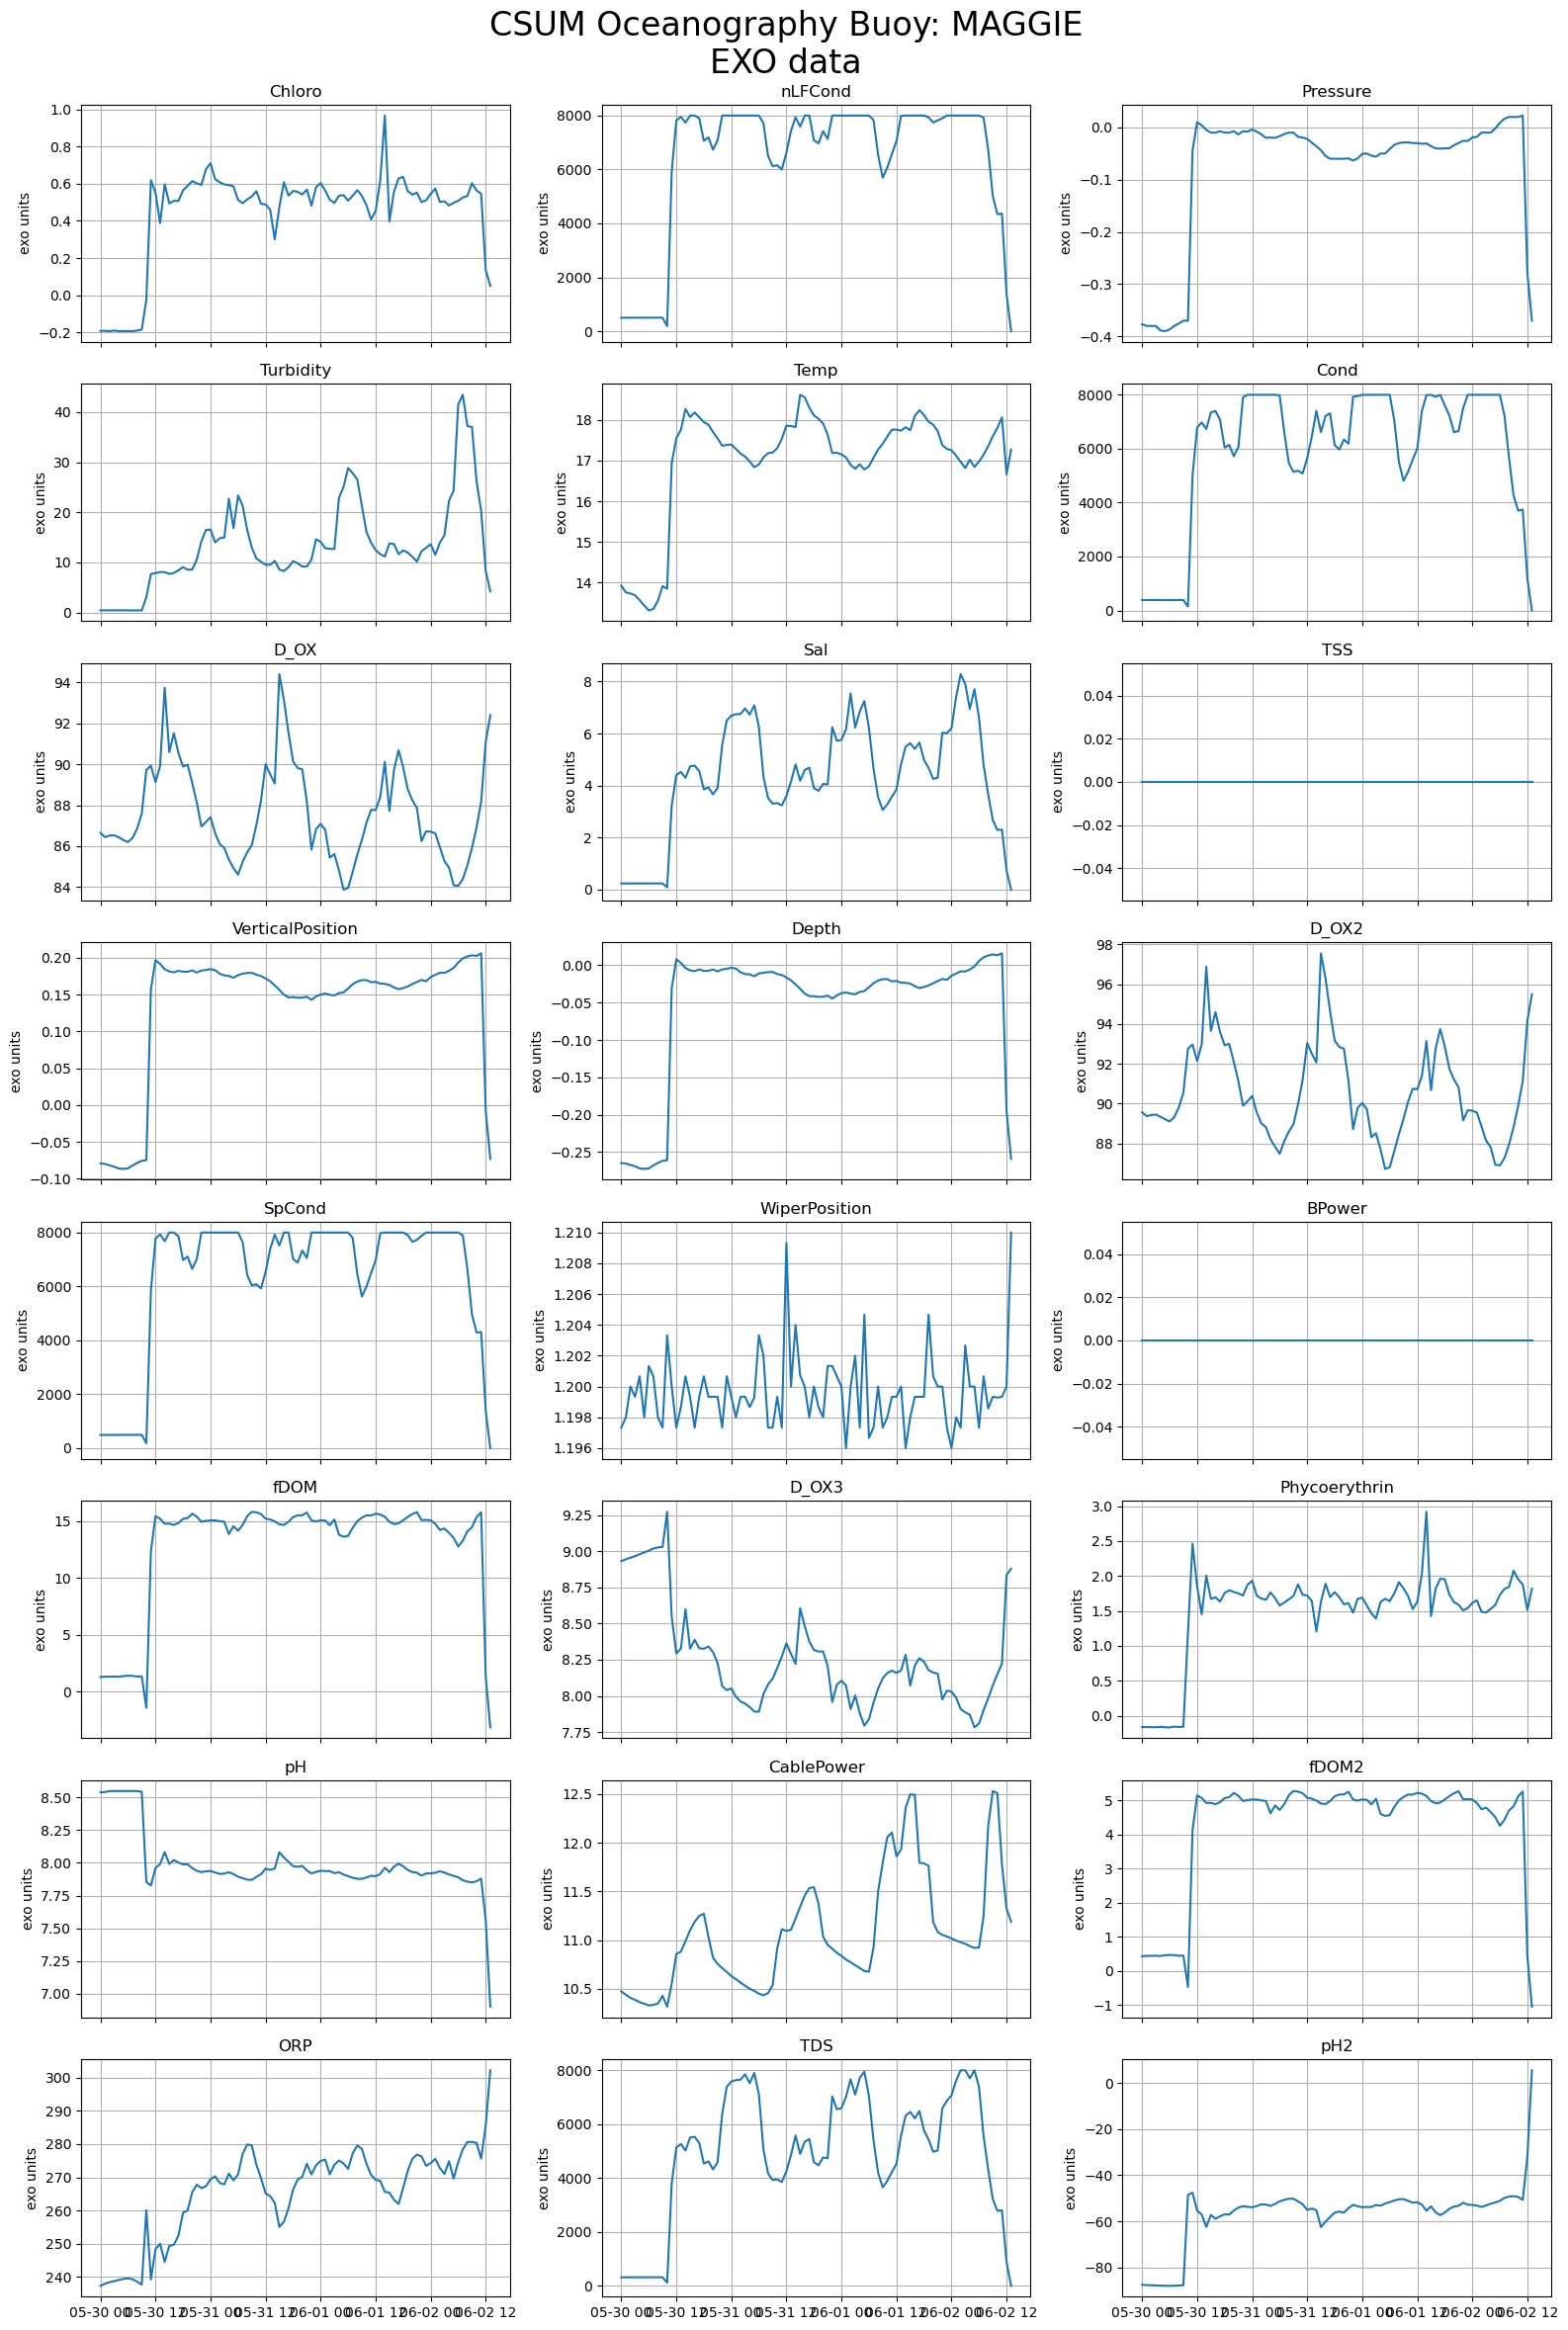

In [3]:
import matplotlib.dates as mdates
# List of variables to plot
exo_plot_variables = ['Chloro', 'nLFCond', 'Pressure', 'Turbidity', 'Temp', 'Cond', 'D_OX', 'Sal',
             'TSS', 'VerticalPosition', 'Depth', 'D_OX2', 'SpCond', 'WiperPosition',
             'BPower', 'fDOM', 'D_OX3', 'Phycoerythrin', 'pH', 'CablePower', 'fDOM2',
             'ORP', 'TDS', 'pH2']

num_variables = 24 #(or do len(exo_plot_variables))
cols = 3
rows = 8

fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 3 * rows), sharex=True)

for i, var in enumerate(exo_plot_variables):
    row = i // cols
    col = i % cols
    ax[row, col].plot(exo_hr.index, getattr(exo_hr, var))
    ax[row, col].set_ylabel('exo units')  # Adjust units for each variable
    ax[row, col].set_title(var)
    ax[row, col].grid()

fig.suptitle("CSUM Oceanography Buoy: MAGGIE\nEXO data",fontsize=24)

fig.tight_layout()
fig.subplots_adjust(top=0.94)  # ^ top margin


In [4]:
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows), sharex=True)

for i, var in enumerate(exo_plot_variables):
    row = i // cols
    col = i % cols
    ax[row, col].plot(exo_hr.index, getattr(exo_hr, var), color='lime')  # Set line color to green
    ax[row, col].set_ylabel('exo units',color='white')  # Adjust units for each variable
    ax[row, col].set_title(var,color='white')
    ax[row, col].set_facecolor('black')  # Set background color to black
    ax[row, col].tick_params(axis='x', colors='white')  # Set x-axis tick color to white
    ax[row, col].tick_params(axis='y', colors='white')  # Set y-axis tick color to white
    ax[row, col].grid(color='green')  # Set gridline color to green

fig.patch.set_facecolor('black')  # Set background color outside the subplots to light gray
fig.suptitle("CSUM Oceanography Buoy: MAGGIE\nEXO data",fontsize=24,color='white')

fig.tight_layout()
fig.subplots_adjust(top=0.94)  # ^ top margin

save_close_plot(fig,'exo black')


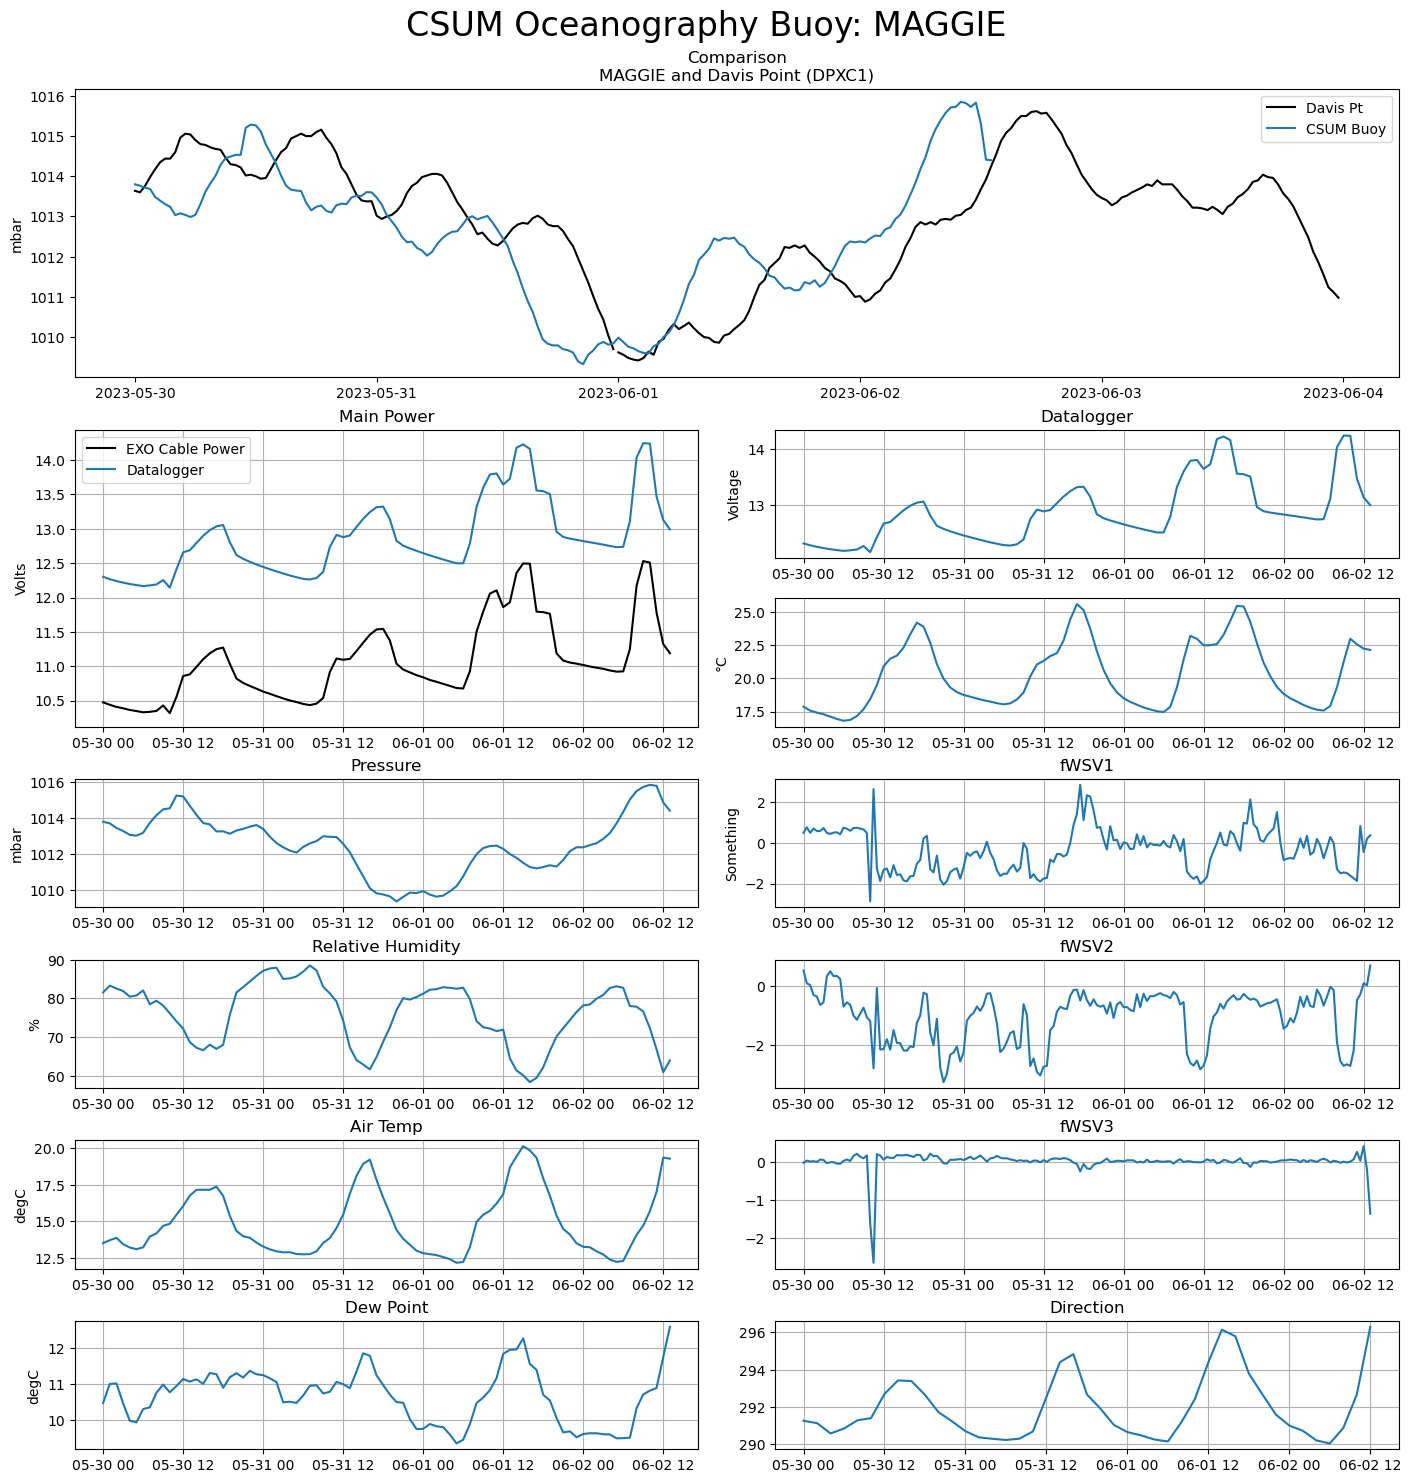

In [6]:
from matplotlib.gridspec import GridSpec

# def format_axes(fig):
#     for i, ax in enumerate(fig.axes):
#         ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
#         ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(14,16),layout="constrained")

gs = GridSpec(9, 12, figure=fig)

# top
ax1 = fig.add_subplot(gs[:2, :])

# left side two size
ax2 = fig.add_subplot(gs[2:4, :-6])

# left side one size
ax3 = fig.add_subplot(gs[4, :-6])
ax4 = fig.add_subplot(gs[5, :-6])
ax5 = fig.add_subplot(gs[6, :-6])
ax6 = fig.add_subplot(gs[7, :-6])

# right side
ax7 = fig.add_subplot(gs[2,6:])
ax8 = fig.add_subplot(gs[3,6:])
ax9 = fig.add_subplot(gs[4,6:])
ax10 = fig.add_subplot(gs[5,6:])
ax11 = fig.add_subplot(gs[6,6:])
ax12 = fig.add_subplot(gs[7,6:])

ax1.plot(davisjune_hhr.index,davisjune_hhr.PRES,color='k')
ax1.plot(davismay_hhr.index,davismay_hhr.PRES,color='k',label='Davis Pt')
ax1.plot(met_hhr.index,met_hhr.BP,label='CSUM Buoy')
ax1.set_ylabel('mbar')
ax1.set_title('Comparison\nMAGGIE and Davis Point (DPXC1)')
ax1.legend()

ax2.plot(exo_hr.index,exo_hr.CablePower,label='EXO Cable Power',color='black')
ax2.plot(datlog_hr.index,datlog_hr.BattV,label='Datalogger')
ax2.legend()
ax2.set_ylabel('Volts')
ax2.set_title('Main Power')

ax3.plot(met_hr.index,met_hr.BP)
ax3.set_ylabel('mbar')
ax3.set_title('Pressure')

ax4.plot(met_hr.index,met_hr.RH)
ax4.set_ylabel('%')
ax4.set_title('Relative Humidity')

ax5.plot(met_hr.index,met_hr.AirTemp)
ax5.set_ylabel('degC')
ax5.set_title('Air Temp')

ax6.plot(met_hr.index,met_hr.DP)
ax6.set_ylabel('degC')
ax6.set_title('Dew Point')

ax7.set_title('Datalogger')
ax7.plot(datlog_hr.index,datlog_hr.BattV)
ax7.set_ylabel('Voltage')

ax8.plot(datlog_hr.index,datlog_hr.PTemp)
ax8.set_ylabel('\u00b0C')
ax8.grid()

ax9.plot(ws_hhr.index,ws_hhr.fWSV1)
ax9.set_ylabel('Something') #dunno
ax9.set_title('fWSV1')

ax10.plot(ws_hhr.index,ws_hhr.fWSV2)
ax10.set_title('fWSV2')

ax11.plot(ws_hhr.index,ws_hhr.fWSV3)
ax11.set_title('fWSV3')

ax12.plot(ws_2hr.index,ws_2hr.fWSC)
ax12.set_title('Direction')

ax2.grid(),ax3.grid(),ax4.grid(),ax5.grid(),ax6.grid(),ax7.grid(),ax9.grid(),ax10.grid(),ax11.grid(),ax12.grid()

fig.suptitle("CSUM Oceanography Buoy: MAGGIE",fontsize=24)

# 1/3 plots at
# ax13 = fig.add_subplot(gs[8,:-8])
# ax14 = fig.add_subplot(gs[8,-8:-4])
# ax15 = fig.add_subplot(gs[8,-4:])

# format_axes(fig)
plt.show()

save_close_plot(fig,'buoy white')


In [5]:
# def format_axes(fig):
#     for i, ax in enumerate(fig.axes):
#         ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
#         ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(14,16),layout="constrained")

gs = GridSpec(9, 12, figure=fig)

# top
ax1 = fig.add_subplot(gs[:2, :])

# left side two size
ax2 = fig.add_subplot(gs[2:4, :-6])

# left side one size
ax3 = fig.add_subplot(gs[4, :-6])
ax4 = fig.add_subplot(gs[5, :-6])
ax5 = fig.add_subplot(gs[6, :-6])
ax6 = fig.add_subplot(gs[7, :-6])

# right side
ax7 = fig.add_subplot(gs[2,6:])
ax8 = fig.add_subplot(gs[3,6:])
ax9 = fig.add_subplot(gs[4,6:])
ax10 = fig.add_subplot(gs[5,6:])
ax11 = fig.add_subplot(gs[6,6:])
ax12 = fig.add_subplot(gs[7,6:])

ax1.plot(davisjune_hhr.index,davisjune_hhr.PRES,color='lime')
ax1.plot(davismay_hhr.index,davismay_hhr.PRES,color='lime',label='Davis Pt')
ax1.plot(met_hhr.index,met_hhr.BP,label='CSUM Buoy',color='red')
ax1.set_ylabel('mbar',color='white')
ax1.set_title('Comparison\nMAGGIE and Davis Point (DPXC1)',color='white')
legend1 = ax1.legend()
legend1.get_frame().set_facecolor('#3A3A3A')  

for text in legend1.get_texts():
    text.set_color('white')  

ax2.plot(exo_hr.index,exo_hr.CablePower,label='EXO Cable Power',color='lime')
ax2.plot(datlog_hr.index,datlog_hr.BattV,label='Datalogger',color='red')
ax2.set_ylabel('Volts',color='white')
ax2.set_title('Main Power',color='white')
legend2 = ax2.legend()
legend2.get_frame().set_facecolor('#3A3A3A')  
for text in legend2.get_texts():
    text.set_color('white')  

ax3.plot(met_hr.index,met_hr.BP,color='lime')
ax3.set_ylabel('mbar',color='white')
ax3.set_title('Pressure',color='white')

ax4.plot(met_hr.index,met_hr.RH,color='lime')
ax4.set_ylabel('%',color='white')
ax4.set_title('Relative Humidity',color='white')

ax5.plot(met_hr.index,met_hr.AirTemp,color='lime')
ax5.set_ylabel('degC',color='white')
ax5.set_title('Air Temp',color='white')

ax6.plot(met_hr.index,met_hr.DP,color='lime')
ax6.set_ylabel('degC',color='white')
ax6.set_title('Dew Point',color='white')

ax7.set_title('Datalogger',color='white')
ax7.plot(datlog_hr.index,datlog_hr.BattV,color='lime')
ax7.set_ylabel('Voltage',color='white')

ax8.plot(datlog_hr.index,datlog_hr.PTemp,color='lime')
ax8.set_ylabel('\u00b0C',color='white')
ax8.grid()

ax9.plot(ws_hhr.index,ws_hhr.fWSV1,color='lime')
ax9.set_ylabel('Something') #dunno
ax9.set_title('fWSV1',color='white')

ax10.plot(ws_hhr.index,ws_hhr.fWSV2,color='lime')
ax10.set_title('fWSV2',color='white')

ax11.plot(ws_hhr.index,ws_hhr.fWSV3,color='lime')
ax11.set_title('fWSV3',color='white')

ax12.plot(ws_2hr.index,ws_2hr.fWSC,color='lime')
ax12.set_title('Direction',color='white')

# ax1.grid(color='green'),ax2.grid(color='green'),ax3.grid(color='green'),ax4.grid(color='green'),ax5.grid(color='green'),ax6.grid(color='green'),ax7.grid(color='green'),ax9.grid(color='green'),ax10.grid(color='green'),ax11.grid(color='green'),ax12.grid(color='green')

# Plot on each axis
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for ax in axes:
    ax.grid(color='green')
    ax.set_facecolor('black')  # Change 'lightgrey' to the desired color
    ax.set_facecolor('black')  # Set background color to black
    ax.tick_params(axis='x', colors='white')  # Set x-axis tick color to white
    ax.tick_params(axis='y', colors='white')  # Set y-axis tick color to white

fig.patch.set_facecolor('black')  # Set background color outside the subplots to light gray

fig.suptitle("CSUM Oceanography Buoy: MAGGIE",fontsize=24,color='white')

# 1/3 plots at
# ax13 = fig.add_subplot(gs[8,:-8])
# ax14 = fig.add_subplot(gs[8,-8:-4])
# ax15 = fig.add_subplot(gs[8,-4:])

# format_axes(fig)
save_close_plot(fig,'buoy black')
